In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
using BenchmarkTools

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1317


In [2]:
@model [ default_factorisation = MeanField() ] function gaussian_mixture_model(n)
    
    s ~ Beta(1.0, 1.0)
    
    m1 ~ NormalMeanVariance(-2.0, 1e3)
    w1 ~ GammaShapeRate(0.01, 0.01)
    
    m2 ~ NormalMeanVariance(2.0, 1e3)
    w2 ~ GammaShapeRate(0.01, 0.01)
    
    z = randomvar(n)
    y = datavar(Float64, n)
    
    for i in 1:n
        z[i] ~ Bernoulli(s)
        y[i] ~ NormalMixture(z[i], (m1, m2), (w1, w2))
    end
    
    scheduler = schedule_updates(m1, m2, w1, w2)
    
    return s, m1, w1, m2, w2, z, y, scheduler
end

gaussian_mixture_model (generic function with 1 method)

In [3]:
using Random

In [4]:
function inference(data, n_its)
    n = length(data)
    model, (s, m1, w1, m2, w2, z, y, scheduler) = gaussian_mixture_model(n);
    
    mswitch = Vector{Marginal}()
    mm1 = Vector{Marginal}()
    mm2 = Vector{Marginal}()
    mw1 = Vector{Marginal}()
    mw2 = Vector{Marginal}()
    
    fe = Vector{Float64}()
    
    m1sub = subscribe!(getmarginal(m1, IncludeAll()), (ms) -> push!(mm1, ms))
    m2sub = subscribe!(getmarginal(m2, IncludeAll()), (ms) -> push!(mm2, ms))
    w1sub = subscribe!(getmarginal(w1, IncludeAll()), (ms) -> push!(mw1, ms))
    w2sub = subscribe!(getmarginal(w2, IncludeAll()), (ms) -> push!(mw2, ms))
    switchsub = subscribe!(getmarginal(s, IncludeAll()), (ms) -> push!(mswitch, ms))
    
    fesub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe, f))
    
    setmarginal!(s, vague(Beta))
    setmarginal!(m1, NormalMeanVariance(-2.0, 1e3))
    setmarginal!(m2, NormalMeanVariance(2.0, 1e3))
    setmarginal!(w1, vague(GammaShapeRate))
    setmarginal!(w2, vague(GammaShapeRate))
    
    for i in 1:n_its
        update!(y, data)
        release!(scheduler)
    end
    
    unsubscribe!(fesub)
    unsubscribe!(switchsub)
    unsubscribe!(m1sub)
    unsubscribe!(m2sub)
    unsubscribe!(w1sub)
    unsubscribe!(w2sub)
    
    return mswitch, mm1, mm2, mw1, mw2, fe
end

inference (generic function with 1 method)

In [5]:
n = 50

Random.seed!(124)

switch = [ 1/3, 2/3 ]
z      = rand(Categorical(switch), n)
y      = Vector{Float64}(undef, n)

μ1 = -10.0
μ2 = 10.0
w  = 1.777

dists = [
    Normal(μ1, sqrt(inv(w))),
    Normal(μ2, sqrt(inv(w))),
]

for i in 1:n
    y[i] = rand(dists[z[i]])
end

In [6]:
@benchmark inference($y, 10)

BechmarkTools.Trial: 537 samples with 1 evaluations.
 Range (min … max):  6.740 ms … 17.964 ms  ┊ GC (min … max):  0.00% … 45.16%
 Time  (median):     8.342 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   9.314 ms ±  2.535 ms  ┊ GC (mean ± σ):  11.10% ± 16.13%

       ▂██▇▇▆▂                                                
  ▂▃▁▃▆████████▅▃▃▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▂▂▃▄▄▃▃▃▃▄▃▃▃▂▂▂▂▃ ▃
  6.74 ms        Histogram: frequency by time        16.8 ms <

 Memory estimate: 6.70 MiB, allocs estimate: 115144.

In [7]:
@time mswitch, mm1, mm2, mw1, mw2, fe = inference(y, 10);

  0.021534 seconds (117.82 k allocations: 6.868 MiB, 50.16% compilation time)


In [8]:
using Plots

dim(d) = (a) -> map(r -> r[d], a)

dim (generic function with 1 method)

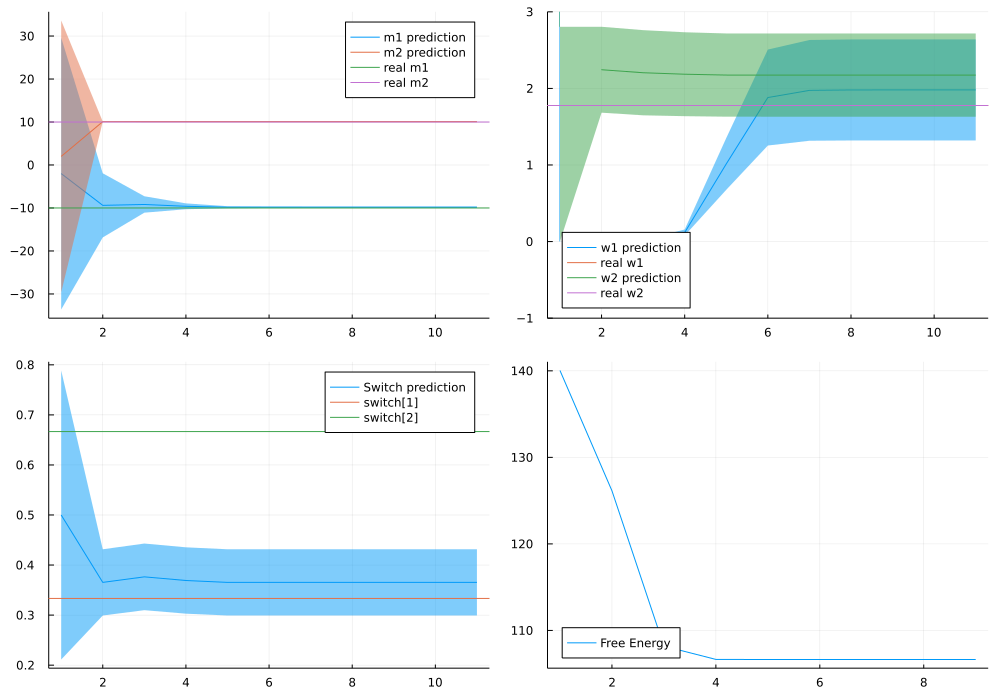

In [9]:
mp = plot(mean.(mm1), ribbon = var.(mm1) .|> sqrt, label = "m1 prediction")
mp = plot!(mean.(mm2), ribbon = var.(mm2) .|> sqrt, label = "m2 prediction")
mp = plot!(mp, [ μ1 ], seriestype = :hline, label = "real m1")
mp = plot!(mp, [ μ2 ], seriestype = :hline, label = "real m2")

wp = plot(mean.(mw1), ribbon = var.(mw1) .|> sqrt, label = "w1 prediction", legend = :bottomleft, ylim = (-1, 3))
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w1")
wp = plot!(wp, mean.(mw2), ribbon = var.(mw2) .|> sqrt, label = "w2 prediction")
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w2")

swp = plot(mean.(mswitch), ribbon = var.(mswitch) .|> sqrt, label = "Switch prediction")

swp = plot!(swp, [ switch[1] ], seriestype = :hline, label = "switch[1]")
swp = plot!(swp, [ switch[2] ], seriestype = :hline, label = "switch[2]")

fep = plot(fe[2:end], label = "Free Energy", legend = :bottomleft)

plot(mp, wp, swp, fep, layout = @layout([ a b; c d ]), size = (1000, 700))